In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn


import zipfile
from google.colab import drive

from torch.utils.data import Dataset
from torchvision.io import read_image
from skimage.color import rgb2lab, lab2rgb
import torch.nn.functional as F

from torch.utils.data import DataLoader

from tqdm.auto import tqdm
from typing import Dict, Tuple, List

from torch.utils.data import TensorDataset


from matplotlib import pyplot as plt
import cv2
import os
from torchvision import transforms
from skimage import io


In [ ]:
#os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive"

In [ ]:
!cd /content/drive/MyDrive/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/task51.zip", 'r')
zip_ref.extractall("/content/task5")
zip_ref.close()

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/My Drive/task51.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
class ImgLoader(torch.utils.data.Dataset):
    def __init__(self,root_dir,transform=None,test=False):
        super().__init__()
        self.root_dir = root_dir
        self.data = os.listdir(root_dir) if not test else  os.listdir(root_dir)[2500:]
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self,i):
        data = cv2.imread(os.path.join(self.root_dir,self.data[i]))
        img = cv2.cvtColor(data, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (160,160), interpolation = cv2.INTER_AREA)
        img = img.astype('float32') / 255.0
        if transform:
            return self.transform(img)
        return img


In [ ]:
transform = transforms.Compose([ transforms.ToTensor()])

In [ ]:
drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/My Drive/task51.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()
color_dir = '/content/task5/landscape Images/color/'
gray_dir = '/content/task5/landscape Images/color/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
batch_size = 128
train = ImgLoader(color_dir,transform)
train_dl = DataLoader(train,batch_size=batch_size,shuffle=True,num_workers=0)
print(len(train_dl)*256)

14336


In [ ]:
i = 0
for img in train_dl:
    print(img.shape)
    i += 1
    if i == 3:
        break

torch.Size([128, 3, 160, 160])
torch.Size([128, 3, 160, 160])
torch.Size([128, 3, 160, 160])


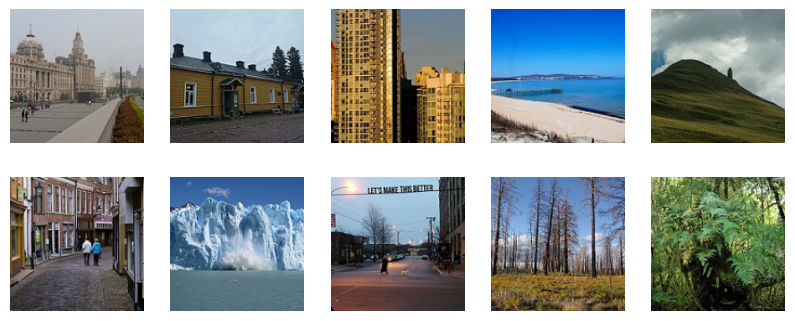

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for i in range(2):
    for j in range(5):
        idx = i * 5 + j
        axs[i, j].imshow(img[idx].permute(1, 2, 0))
        axs[i, j].axis('off')
plt.show()

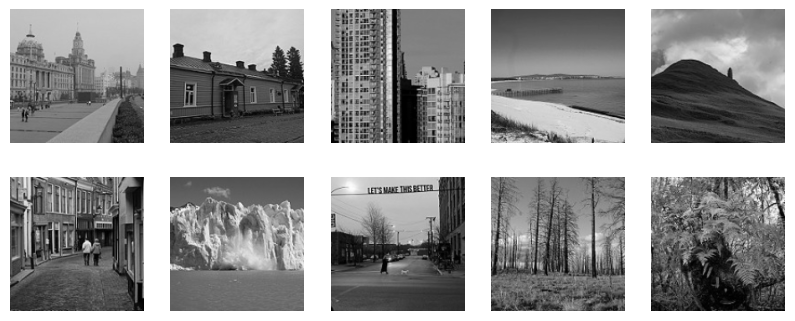

In [ ]:
iimg = transforms.Grayscale(num_output_channels=3)(img)

fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for i in range(2):
    for j in range(5):
        idx = i * 5 + j
        axs[i, j].imshow(iimg[idx].permute(1, 2, 0))
        axs[i, j].axis('off')
plt.show()

In [ ]:
class ColorAutoEnc(nn.Module):
    def __init__(self,n_features=1,kernel_size = 3,n_filters=128):
        super().__init__()
        self.conv1 = nn.Conv2d(n_features,n_filters,kernel_size=kernel_size,stride=1,padding=1)
        self.conv2 = nn.Conv2d(n_filters,n_filters*2,kernel_size=kernel_size,stride=2,padding=1)
        self.conv3 = nn.Conv2d(n_filters*2,n_filters*4,kernel_size=kernel_size,stride=2,padding=1)
        self.conv4 = nn.Conv2d(n_filters*4,n_filters*4,kernel_size=kernel_size,stride=2,padding=1)
        self.pool = nn.MaxUnpool2d(2,2)

        self.t_conv1 = nn.ConvTranspose2d(n_filters*4,n_filters*4,kernel_size=kernel_size,stride=2,padding=1,output_padding=1)
        self.t_conv2 = nn.ConvTranspose2d(n_filters*4,n_filters*2,kernel_size=kernel_size,stride=2,padding=1,output_padding=1)
        self.t_conv3 = nn.ConvTranspose2d(n_filters*2,n_filters*1,kernel_size=kernel_size,stride=2,padding=1,output_padding=1)
        self.t_conv4 = nn.ConvTranspose2d(n_filters*1,64,kernel_size=kernel_size,stride=1,padding=1)
        self.converge = nn.Conv2d(64,3,3,stride=1,padding=1)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        x = F.relu(self.t_conv4(x))
        x =  self.converge(x)
        return x

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
model = ColorAutoEnc().to(device)

In [ ]:
def summarize_model(model):
    print("Model architecture:")
    print(model)
    print("\nLayers:")
    for name, param in model.named_parameters():
        print(f"{name}: {param.shape}")
    print("\nNumber of trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

In [ ]:
summarize_model(model)

Model architecture:
ColorAutoEnc(
  (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (t_conv1): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (t_conv2): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (t_conv3): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (t_conv4): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (converge): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

Layers:
conv1.weight: torch.Size([128, 1, 3, 3])
conv1.bias: torch.Si

In [ ]:
import random
from torch.utils.data import SubsetRandomSampler, DataLoader

dataset_size = len(train_dl.dataset)
train_subset_indices = random.sample(range(dataset_size), k=int(dataset_size * 0.7))
train_subset_sampler = SubsetRandomSampler(train_subset_indices)
train_subset_dataloader = DataLoader(train_dl.dataset, batch_size=train_dl.batch_size, sampler=train_subset_sampler)

test_subset_indices = list(set(range(dataset_size)) - set(train_subset_indices))
test_subset_sampler = SubsetRandomSampler(test_subset_indices)
test_subset_dataloader = DataLoader(train_dl.dataset, batch_size=train_dl.batch_size, sampler=test_subset_sampler)

In [ ]:
import gc
model.to(device)
from tqdm import tqdm
model.to(device)
from tqdm import tqdm
epochs = 10

criterion = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(),lr = .001)
losses = []
for e in tqdm(range(epochs)):
    train_loss = 0.0
    for data in train_subset_dataloader:
        inp = transforms.Grayscale(num_output_channels=1)(data)
        inp,data = inp.to(device),data.to(device)

        optim.zero_grad()
        out = model(inp)
        loss = criterion(out,data)
        loss.backward()
        optim.step()
        train_loss += loss.item()*data.size(0)
        del inp
        del data
        gc.collect()
        torch.cuda.empty_cache()
    train_loss = train_loss/len(train_dl)
    losses.append(train_loss)

    print(f'Epoch: {e+1} / epochs train_loss: {train_loss}  ')

 10%|█         | 1/10 [02:15<20:15, 135.06s/it]

Epoch: 1 / epochs train_loss: 14.605869981061135  


 20%|██        | 2/10 [04:21<17:18, 129.77s/it]

Epoch: 2 / epochs train_loss: 1.9145945013234658  


 30%|███       | 3/10 [06:27<14:57, 128.22s/it]

Epoch: 3 / epochs train_loss: 1.4635889402457647  


 40%|████      | 4/10 [08:35<12:47, 127.96s/it]

Epoch: 4 / epochs train_loss: 1.2791083680931479  


 50%|█████     | 5/10 [10:41<10:36, 127.40s/it]

Epoch: 5 / epochs train_loss: 1.1855609414633363  


 60%|██████    | 6/10 [12:48<08:29, 127.25s/it]

Epoch: 6 / epochs train_loss: 1.133566632135106  


 70%|███████   | 7/10 [14:55<06:21, 127.12s/it]

Epoch: 7 / epochs train_loss: 1.0334293699956365  


 80%|████████  | 8/10 [17:02<04:14, 127.02s/it]

Epoch: 8 / epochs train_loss: 0.970283073639231  


 90%|█████████ | 9/10 [19:08<02:06, 126.98s/it]

Epoch: 9 / epochs train_loss: 0.9218264221147235  


100%|██████████| 10/10 [21:15<00:00, 127.56s/it]

Epoch: 10 / epochs train_loss: 0.8754504527896643  


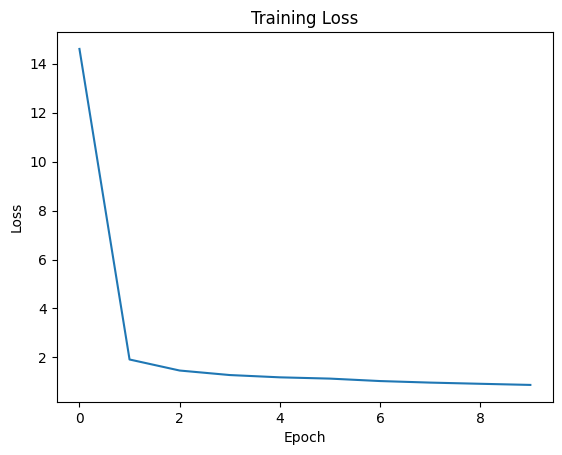

In [ ]:
# Plot loss changes
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
def plot_images(grayscale,predicted):
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)

    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale,cmap='gray')
    plt.subplot(1,2,2)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
    plt.show()

In [ ]:
i = 0
for im in test_subset_dataloader:
    if i > 5:
        break
    data = transforms.Grayscale(num_output_channels=1)(im)
    model.to(torch.device('cpu'))
    out = model(data)
    i += 1
    plot_images(im.permute(1,2,0),out.detach().numpy().transpose((1,2,0)))